In [1]:
#https://github.com/am-shb/gwo-feature-selection

In [2]:
pip install --upgrade seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats  

In [4]:
import numpy as np
import pandas as pd

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import random
import numpy
import math
import time

In [5]:
from typing import Callable
import matplotlib.pyplot as plt

# Data handling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

2024-07-04 18:15:06.173548: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 18:15:06.173610: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 18:15:06.173642: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-04 18:15:06.181581: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
def GWO(objf, lb, ub, dim, SearchAgents_no, Max_iter):
    Alpha_pos = np.zeros(dim)
    Alpha_score = float("inf")
    
    Beta_pos = np.zeros(dim)
    Beta_score = float("inf")
    
    Delta_pos = np.zeros(dim)
    Delta_score = float("inf")

    if not isinstance(lb, list):
        lb = [lb] * dim
    if not isinstance(ub, list):
        ub = [ub] * dim
    
    Positions = np.zeros((SearchAgents_no, dim))
    for i in range(dim):
        Positions[:, i] = np.random.uniform(0, 1, SearchAgents_no) * (ub[i] - lb[i]) + lb[i]
    
    Convergence_curve = np.zeros(Max_iter)

    print("GWO is optimizing  \"" + objf.__name__ + "\"")    
    
    timerStart = time.time()
    
    for l in range(0, Max_iter):
        for i in range(0, SearchAgents_no):
            for j in range(dim):
                Positions[i, j] = np.clip(Positions[i, j], lb[j], ub[j])

            fitness = objf(Positions[i, :])
            
            if fitness < Alpha_score:
                Alpha_score = fitness
                Alpha_pos = Positions[i, :].copy()
            
            if (fitness > Alpha_score and fitness < Beta_score):
                Beta_score = fitness
                Beta_pos = Positions[i, :].copy()
            
            if (fitness > Alpha_score and fitness > Beta_score and fitness < Delta_score):
                Delta_score = fitness
                Delta_pos = Positions[i, :].copy()
        
        a = 2 - l * ((2) / Max_iter)
        
        for i in range(0, SearchAgents_no):
            for j in range(dim):     
                r1 = random.random()
                r2 = random.random()
                
                A1 = 2 * a * r1 - a
                C1 = 2 * r2
                
                D_alpha = abs(C1 * Alpha_pos[j] - Positions[i, j])
                X1 = Alpha_pos[j] - A1 * D_alpha
                           
                r1 = random.random()
                r2 = random.random()
                
                A2 = 2 * a * r1 - a
                C2 = 2 * r2
                
                D_beta = abs(C2 * Beta_pos[j] - Positions[i, j])
                X2 = Beta_pos[j] - A2 * D_beta       
                
                r1 = random.random()
                r2 = random.random() 
                
                A3 = 2 * a * r1 - a
                C3 = 2 * r2
                
                D_delta = abs(C3 * Delta_pos[j] - Positions[i, j])
                X3 = Delta_pos[j] - A3 * D_delta             
                
                Positions[i, j] = (X1 + X2 + X3) / 3
        
        Convergence_curve[l] = Alpha_score

        if (l % 1 == 0):
            print(['At iteration ' + str(l) + ' the best fitness is ' + str(Alpha_score)])
            print('alpha:', np.where(Alpha_pos > 0.5)[0])
    
    timerEnd = time.time()
    print('Completed in', (timerEnd - timerStart))
    
    return Alpha_pos

In [7]:
from scipy import stats
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 10
STEP = 5

In [8]:
# CNN 모델 정의
def create_cnn_model(input_shape, n_outputs):
    model = Sequential()
    model.add(Conv1D(32, 3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.summary()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [9]:
def fitness_function(positions):
    features = np.where(positions >= 0.4999)[0]
    
    if len(features) == 0:
        return float("inf")
    
    try:
        train_xf = train_x[:, :, features]
        test_xf = test_x[:, :, features]
    except IndexError:
        return float("inf")
    
    model = Sequential()
    model.add(Conv1D(32, 3, activation='relu', input_shape=(train_xf.shape[1], len(features))))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.fit(train_xf, trainy_one_hot, epochs=50, batch_size=32, verbose=0)
    
    loss, accuracy = model.evaluate(test_xf, testy_one_hot, verbose=0)
    
    w = 0.9
    return -(w * accuracy + (1 - w) * (1 / len(features)))

In [10]:
# Load the data
data_df = pd.read_csv('mobile_price_dataset/train.csv')
data_df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,...,1222,1890,668,13,4,19,1,1,0,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2
1997,1911,0,0.9,1,1,1,36,0.7,108,8,...,868,1632,3057,9,1,5,1,1,0,3
1998,1512,0,0.9,0,4,1,46,0.1,145,5,...,336,670,869,18,10,19,1,1,1,0


In [11]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

/tmp/ipykernel_4747/1044639550.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = data_df, x="price_range", palette="viridis")


Text(0.5, 1.0, 'Label')

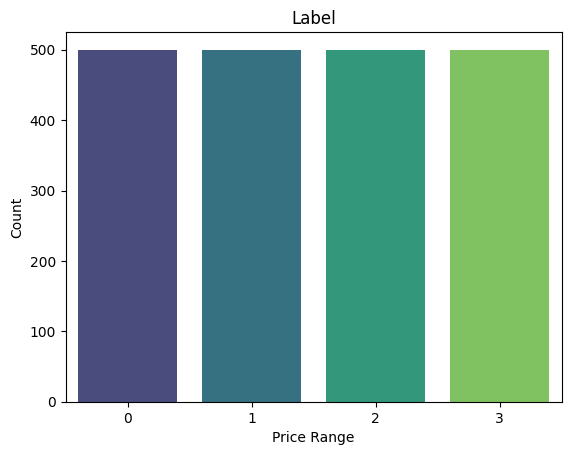

In [12]:
# 레이블 갯수 확인 (그래프)
sns.countplot(data = data_df, x="price_range", palette="viridis")
plt.xlabel("Price Range")
plt.ylabel("Count")
plt.title("Label")

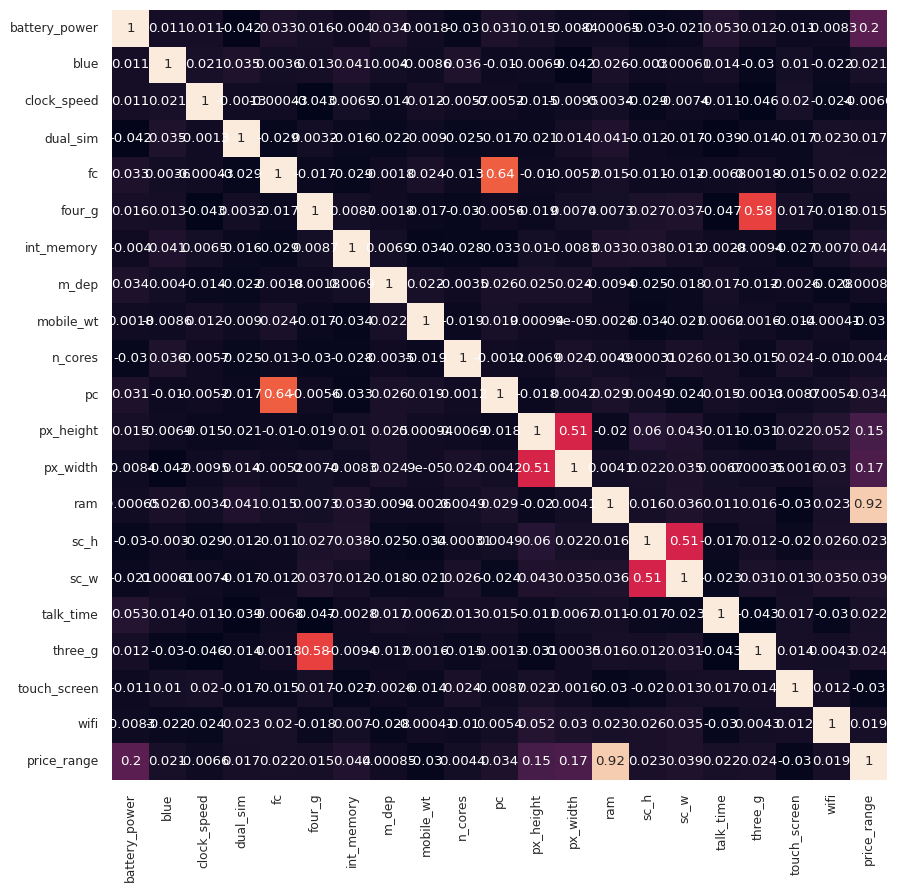

In [13]:
df_corr=data_df.corr()

#히트맵
plt.figure(figsize=(10,10))
sns.set(font_scale=0.8)
sns.heatmap(df_corr, annot=True, cbar=False)
plt.show()

In [14]:
last_row_corr = df_corr.iloc[-1]

last_row_corr 

battery_power    0.200723
blue             0.020573
clock_speed     -0.006606
dual_sim         0.017444
fc               0.021998
four_g           0.014772
int_memory       0.044435
m_dep            0.000853
mobile_wt       -0.030302
n_cores          0.004399
pc               0.033599
px_height        0.148858
px_width         0.165818
ram              0.917046
sc_h             0.022986
sc_w             0.038711
talk_time        0.021859
three_g          0.023611
touch_screen    -0.030411
wifi             0.018785
price_range      1.000000
Name: price_range, dtype: float64

In [15]:
data_df.columns

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')

In [16]:
data_df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,...,1222,1890,668,13,4,19,1,1,0,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2
1997,1911,0,0.9,1,1,1,36,0.7,108,8,...,868,1632,3057,9,1,5,1,1,0,3
1998,1512,0,0.9,0,4,1,46,0.1,145,5,...,336,670,869,18,10,19,1,1,1,0


In [17]:
X, y = create_dataset(data_df[['battery_power', 'px_height','px_width', 'ram']], data_df[['price_range']], TIME_STEPS,
                                  STEP)

In [18]:
X

array([[[ 842,   20,  756, 2549],
        [1021,  905, 1988, 2631],
        [ 563, 1263, 1716, 2603],
        ...,
        [1954,  512, 1149,  700],
        [1445,  386,  836, 1099],
        [ 509, 1137, 1224,  513]],

       [[1859, 1004, 1654, 1067],
        [1821,  381, 1018, 3220],
        [1954,  512, 1149,  700],
        ...,
        [1815,  607,  748, 1482],
        [ 803,  344, 1440, 2680],
        [1866,  356,  563,  373]],

       [[ 769,  248,  874, 3946],
        [1520,  151, 1005, 3826],
        [1815,  607,  748, 1482],
        ...,
        [ 595,  441,  810, 3752],
        [1131,  658,  878, 1835],
        [ 682,  902, 1064, 2337]],

       ...,

       [[1157, 1694, 1798, 2885],
        [1201,  306,  558,  495],
        [1379,  838,  885, 2358],
        ...,
        [1784,  610, 1437, 2313],
        [1262,  223,  737, 3248],
        [ 797,  206, 1167, 2216]],

       [[ 930, 1017, 1289, 2016],
        [1454,  698, 1018, 1300],
        [1784,  610, 1437, 2313],
        .

In [19]:
y

array([[0],
       [0],
       [3],
       [1],
       [3],
       [3],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [3],
       [3],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [3],
       [3],
       [1],
       [3],
       [3],
       [1],
       [1],
       [0],
       [2],
       [1],
       [1],
       [0],
       [2],
       [3],
       [2],
       [0],
       [3],
       [3],
       [2],
       [2],
       [2],
       [2],
       [0],
       [3],
       [3],
       [3],
       [0],
       [2],
       [2],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [3],
       [3],
       [0],
       [0],
       [2],
       [0],
       [0],
       [0],
       [1],
       [1],
       [2],
       [2],
       [2],
       [0],
       [0],
       [0],
       [3],
       [3],
       [2],
       [2],
       [3],
       [3],
       [3],
       [2],
       [3],
       [1],
    

In [20]:
num_features = data_df.shape[1]

In [21]:
train_x, test_x, train_y, test_y = train_test_split(X, y,test_size=0.25,random_state=0)
print ('train_x shape:', train_x.shape)
print ('train_y shape:', train_y.shape)
print ('test_x shape:', test_x.shape)
print ('test_y shape:', test_y.shape)

train_x shape: (298, 10, 4)
train_y shape: (298, 1)
test_x shape: (100, 10, 4)
test_y shape: (100, 1)


In [22]:
trainy_one_hot = to_categorical(train_y)
testy_one_hot = to_categorical(test_y)

In [23]:
train_x

array([[[1053,  419, 1261, 1339],
        [1944, 1111, 1362, 2560],
        [1174, 1097, 1461,  285],
        ...,
        [1528,  306,  564,  733],
        [ 875,  300, 1316,  756],
        [1602, 1259, 1746, 3622]],

       [[ 697,  478, 1477,  259],
        [ 717,  217, 1106,  688],
        [1348,  468,  741, 2554],
        ...,
        [1558,  322, 1385,  878],
        [1597,  880, 1145, 2130],
        [1240, 1511, 1756, 3260]],

       [[ 856,  395, 1027, 2439],
        [ 714,  643, 1527, 2302],
        [ 951,  854,  935, 1083],
        ...,
        [1987,  960, 1925,  857],
        [ 908,  154,  941, 3518],
        [ 820,  468,  694, 1284]],

       ...,

       [[ 739, 1052, 1536,  475],
        [ 704, 1108, 1509, 1122],
        [1663,  951, 1545, 1336],
        ...,
        [1263,  178, 1883, 1183],
        [1395,  782, 1787, 3373],
        [ 621,  434,  910, 2801]],

       [[1523,  148, 1606,  707],
        [1133,  730, 1543, 1457],
        [1718,  564,  980, 3755],
        .

In [24]:
trainy_one_hot.shape

(298, 4)

In [25]:
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], trainy_one_hot.shape[1]

In [26]:
model = create_cnn_model((n_timesteps, n_features),n_outputs)
model.fit(train_x, trainy_one_hot, epochs=30, batch_size=32, validation_data=(test_x, testy_one_hot))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 32)             416       
                                                                 
 max_pooling1d (MaxPooling1  (None, 4, 32)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 64)             6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 50)                3

2024-07-04 18:15:10.536114: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38698 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:8c:00.0, compute capability: 8.0
2024-07-04 18:15:10.538448: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38698 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:c8:00.0, compute capability: 8.0
2024-07-04 18:15:11.875266: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-07-04 18:15:12.174009: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f02f91f2e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-04 18:15:12.174056: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2024-07-04 18:15:12.174063: I tensorflow/compiler/xla

10/10 [==============================] - 2s 39ms/step - loss: 98.2208 - accuracy: 0.2148 - val_loss: 68.8865 - val_accuracy: 0.2300
Epoch 2/30
10/10 [==============================] - 0s 12ms/step - loss: 44.6386 - accuracy: 0.2584 - val_loss: 50.9434 - val_accuracy: 0.1800
Epoch 3/30
10/10 [==============================] - 0s 8ms/step - loss: 34.2157 - accuracy: 0.3054 - val_loss: 40.1414 - val_accuracy: 0.2400
Epoch 4/30
10/10 [==============================] - 0s 7ms/step - loss: 25.4165 - accuracy: 0.3691 - val_loss: 33.3496 - val_accuracy: 0.3000
Epoch 5/30
10/10 [==============================] - 0s 7ms/step - loss: 21.2818 - accuracy: 0.3926 - val_loss: 32.7329 - val_accuracy: 0.3200
Epoch 6/30
10/10 [==============================] - 0s 7ms/step - loss: 18.0736 - accuracy: 0.4530 - val_loss: 29.8122 - val_accuracy: 0.3400
Epoch 7/30
10/10 [==============================] - 0s 7ms/step - loss: 15.2271 - accuracy: 0.4396 - val_loss: 28.3163 - val_accuracy: 0.3300
Epoch 8/30
10/1

# Gwo-Feature-Selection

In [27]:
num_features = 20

In [28]:
# Load the data
data_df = pd.read_csv('mobile_price_dataset/train.csv')

In [29]:
train_data, test_data = train_test_split(data_df)

In [30]:
#train_data = pd.read_csv('mobile_price_dataset/train.csv')

In [31]:
#test_data = pd.read_csv('mobile_price_dataset/test.csv')

In [32]:
train_X, train_Y = create_dataset(train_data.iloc[:, :num_features], train_data.iloc[:, -1], TIME_STEPS,
                                  STEP)

In [33]:
test_X, test_Y = create_dataset(test_data.iloc[:, :num_features], test_data.iloc[:, -1], TIME_STEPS,
                                  STEP)

In [34]:
train_x, test_x, train_y, test_y = train_X, test_X, train_Y, test_Y
print ('train_x shape:', train_x.shape)
print ('train_y shape:', train_y.shape)
print ('test_x shape:', test_x.shape)
print ('test_y shape:', test_y.shape)

train_x shape: (298, 10, 20)
train_y shape: (298, 1)
test_x shape: (98, 10, 20)
test_y shape: (98, 1)


In [35]:
trainy_one_hot = to_categorical(train_y)
testy_one_hot = to_categorical(test_y)

In [36]:
print(trainy_one_hot.shape)

(298, 4)


In [37]:
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], trainy_one_hot.shape[1]

In [38]:
#train_y = train_df.iloc[:, 41]
#test_y = test_df.iloc[:, 41]


# Feature selection using GWO

fit = GWO(fitness_function, 0, 1, num_features, 10, 20)
selected_features = np.where(fit>0.5)[0]
#selected_features = [9,13,14,39]
print(selected_features)

GWO is optimizing  "fitness_function"
['At iteration 0 the best fitness is -0.41317253681746396']
alpha: [ 0  2  4  6  7  8  9 10 13 17 18]
['At iteration 1 the best fitness is -0.4140816277265549']
alpha: [ 1  2  3  4  5 10 12 13 14 16]
['At iteration 2 the best fitness is -0.4257652968168259']
alpha: [ 0  2  4  5  8 13 14 16]
['At iteration 3 the best fitness is -0.4482993284861247']
alpha: [ 3  4 11 13 14 16]
['At iteration 4 the best fitness is -0.4482993284861247']
alpha: [ 3  4 11 13 14 16]
['At iteration 5 the best fitness is -0.4482993284861247']
alpha: [ 3  4 11 13 14 16]
['At iteration 6 the best fitness is -0.4942176739374797']
alpha: [ 2  4  9 12 13 14]
['At iteration 7 the best fitness is -0.4942176739374797']
alpha: [ 2  4  9 12 13 14]
['At iteration 8 the best fitness is -0.4942176739374797']
alpha: [ 2  4  9 12 13 14]
['At iteration 9 the best fitness is -0.4942176739374797']
alpha: [ 2  4  9 12 13 14]
['At iteration 10 the best fitness is -0.4942176739374797']
alpha: [

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [ ]:
train_x = train_x[:, :, selected_features]
test_x = test_x[:, :, selected_features]

In [39]:
model = create_cnn_model(train_x.shape[1], train_x.shape[2])
history = model.fit(train_x, trainy_one_hot, epochs=30, batch_size=32, validation_data=(test_x, testy_one_hot))

TypeError: 'int' object is not iterable

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, f1_score

y_pred=model.predict(test_x)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(testy_one_hot, axis=-1)

LABELS = ['0','1','2','3']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')